In [81]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.optimize import curve_fit
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.linear_model import LogisticRegression
from statsmodels.genmod.families import Gaussian
from statsmodels.genmod.families.links import log as log_link
import pandas as pd

!git clone https://github.com/e-n-f/housing-inventory.git


fatal: destination path 'housing-inventory' already exists and is not an empty directory.


# Reading the Data

In [82]:
# Load the file, assuming the first column contains both the year and median rent separated by a space
# Adjust the path to where you've stored 'combined' in your Google Drive
file_path = 'housing-inventory/combined.csv'

# Assuming the file 'combined.csv' is in the current directory in Colab
combined = pd.read_csv(file_path, header=None, usecols=range(6))

# Extract year and median rent from the first column
combined['year'] = combined[0].str.extract(r'(\d+)')[0].astype(float)  # Keep as float to avoid ValueError due to NaN
combined['median_rent'] = combined[0].str.extract(r' (\d+)')[0].astype(float)

# Drop the original first column and rename columns
combined.drop(columns=[0], inplace=True)
combined.columns = ['year', 'median_rent', 'housing_units', 'net_new_housing', 'employment', 'total_wages', 'CPI']

# Display the first few rows and summary of the DataFrame
print(combined.head())
print(combined.describe())

          year    median_rent    housing_units net_new_housing   employment  \
0  median_rent  housing_units  net_new_housing      employment  total_wages   
1          NaN          84077             8444             NaN          NaN   
2          NaN         100342            16265             NaN          NaN   
3          NaN         111220            10878             NaN          NaN   
4          NaN         117465             6245             NaN          NaN   

   total_wages  CPI  
0          NaN  NaN  
1       1906.0  NaN  
2       1907.0  NaN  
3       1908.0  NaN  
4       1909.0  NaN  
       total_wages  CPI
count   111.000000  0.0
mean   1961.000000  NaN
std      32.186954  NaN
min    1906.000000  NaN
25%    1933.500000  NaN
50%    1961.000000  NaN
75%    1988.500000  NaN
max    2016.000000  NaN


# Trends




This set of Python code does the following: plots nominal and real rental rates with log scaling, applies a LOWESS smoother to visualize trends, and fits a GLM model to analyze the annual increase in real rent,

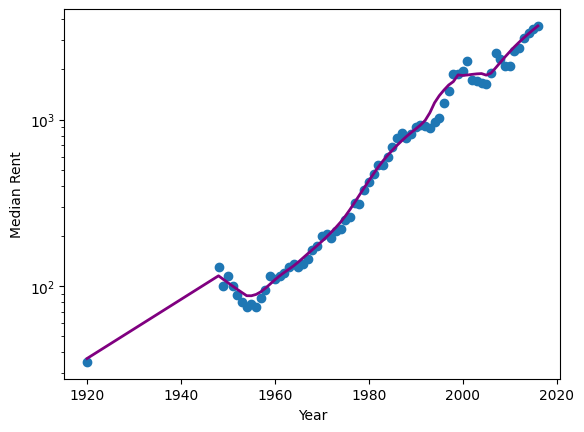

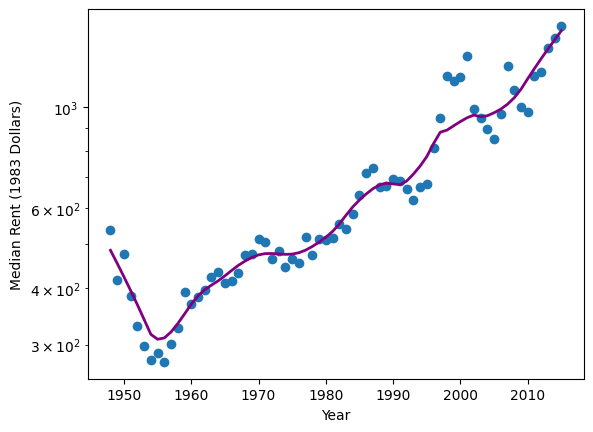

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


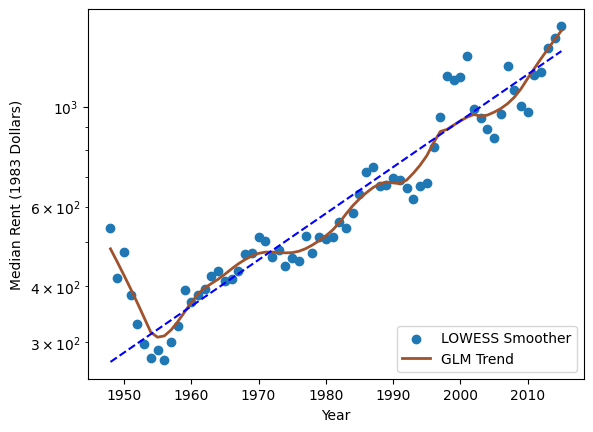

Annual increase= 1.0239617751406183


In [41]:
# Assuming 'SF' DataFrame is already defined and has 'year', 'median_rent', 'CPI'
SF = pd.read_csv('/content/housing-inventory/combined.csv')

### Plot Nominal Rental Rates
# Assuming 'SF' is your DataFrame with 'year' and 'median_rent' columns
plt.scatter(SF['year'], SF['median_rent'])
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Median Rent')
# Adding LOWESS smoother
lowess_smoothed = lowess(SF['median_rent'], SF['year'], frac=0.2)
plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color='purple', linewidth=2)
plt.show()

### Real Rental Rates (adjusting for CPI) with smoother
SF['real84_median_rent'] = SF['median_rent'] / SF['CPI']
SF_post1948 = SF[SF['year'] >= 1948]

plt.scatter(SF_post1948['year'], SF_post1948['real84_median_rent'])
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Median Rent (1983 Dollars)')
# Adding LOWESS smoother
lowess_smoothed = lowess(SF_post1948['real84_median_rent'], SF_post1948['year'], frac=0.2)
plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color='purple', linewidth=2)
plt.show()

### With Trend Line
SFok = SF[(SF['year'] >= 1948) & (SF['year'] <= 2015)].copy()
SFok['real84_median_rent'] = SFok['median_rent'] / SFok['CPI']

# Fitting a GLM model
trend_model = glm('real84_median_rent ~ year', family=Gaussian(link=log_link()), data=SFok).fit()

plt.scatter(SFok['year'], SFok['real84_median_rent'])
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Median Rent (1983 Dollars)')
# Adding LOWESS smoother
lowess_smoothed = lowess(SFok['real84_median_rent'], SFok['year'], frac=0.2)
plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color='sienna', linewidth=2)
# Plotting fitted values from GLM
plt.plot(SFok['year'], np.exp(trend_model.params['Intercept'] + trend_model.params['year'] * SFok['year']), linestyle='--', color='blue')
plt.legend(['LOWESS Smoother', 'GLM Trend'], loc='lower right')
plt.show()
print("Annual increase=", np.exp(trend_model.params['year']))

###fixing the error
# Fixing SettingWithCopyWarning
SFok = SFok.copy()
SFok.loc[:, 'real84_median_rent'] = SFok['median_rent'] / SFok['CPI']



# Models

                                 OLS Regression Results                                 
Dep. Variable:     np.log10(real84_median_rent)   R-squared:                       0.951
Model:                                      OLS   Adj. R-squared:                  0.947
Method:                           Least Squares   F-statistic:                     233.7
Date:                          Mon, 26 Feb 2024   Prob (F-statistic):           1.20e-23
Time:                                  17:57:24   Log-Likelihood:                 80.771
No. Observations:                            40   AIC:                            -153.5
Df Residuals:                                36   BIC:                            -146.8
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------

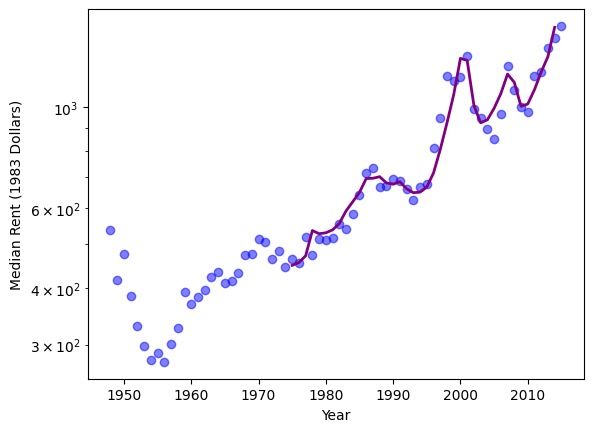

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


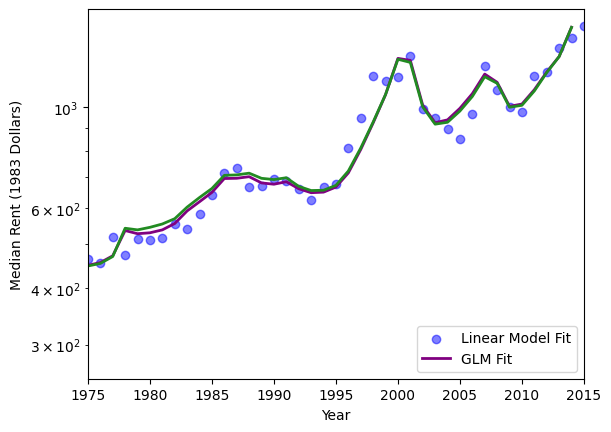

In [37]:
# Define the linear model for logarithms
pricemodel = smf.ols('np.log10(real84_median_rent) ~ np.log10(housing_units) + np.log10(employment) + np.log10(total_wages / CPI)', data=SFok).fit()
print(pricemodel.summary())

##add fitted values to sfok
SFok['fitted'] = np.nan  # Initialize column with NaNs
SFok.loc[pricemodel.fittedvalues.index, 'fitted'] = 10**pricemodel.fittedvalues  # Assign fitted values

# Plotting the original data and the model predictions
plt.scatter(SFok['year'], SFok['real84_median_rent'], color='blue', alpha=0.5)
plt.plot(SFok['year'], SFok['fitted'], color='purple', linewidth=2)  # Use 'fitted' column
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Median Rent (1983 Dollars)')
plt.show()

# GLM model equivalent
pricemodel2 = smf.glm('real84_median_rent ~ np.log10(housing_units) + np.log10(employment) + np.log10(total_wages / CPI)',
                      data=SFok,
                      family=sm.families.Gaussian(link=log_link())).fit()

# Coefficients adjustment
adjusted_coefs = pricemodel2.params / np.log(10)

# Add a column for fitted values from the first model to SFok
SFok['fitted_model'] = np.nan  # Initialize with NaN
SFok.loc[pricemodel.fittedvalues.index, 'fitted_model'] = 10**pricemodel.fittedvalues

# Add a column for fitted values from the second model to SFok
SFok['fitted_model2'] = np.nan  # Initialize with NaN
SFok.loc[pricemodel2.fittedvalues.index, 'fitted_model2'] = pricemodel2.fittedvalues

# Plotting both models' predictions
plt.scatter(SFok['year'], SFok['real84_median_rent'], color='blue', alpha=0.5)
plt.plot(SFok.dropna(subset=['fitted_model'])['year'], SFok.dropna(subset=['fitted_model'])['fitted_model'], color='purple', linewidth=2)
plt.plot(SFok.dropna(subset=['fitted_model2'])['year'], SFok.dropna(subset=['fitted_model2'])['fitted_model2'], color='forestgreen', linewidth=2)
plt.yscale('log')
plt.xlabel('Year')
plt.ylabel('Median Rent (1983 Dollars)')
plt.xlim([1975, 2015])
plt.legend(['Linear Model Fit', 'GLM Fit'], loc='lower right')
plt.show()

As Eric found, San Francisco real median asking prices for rentals have been going up about 2.5% per year since the 1950s,  and can be modelled quite accurately since 1975 using employment, real salaries and wages, and number of housing units.

# PDF AND CDF

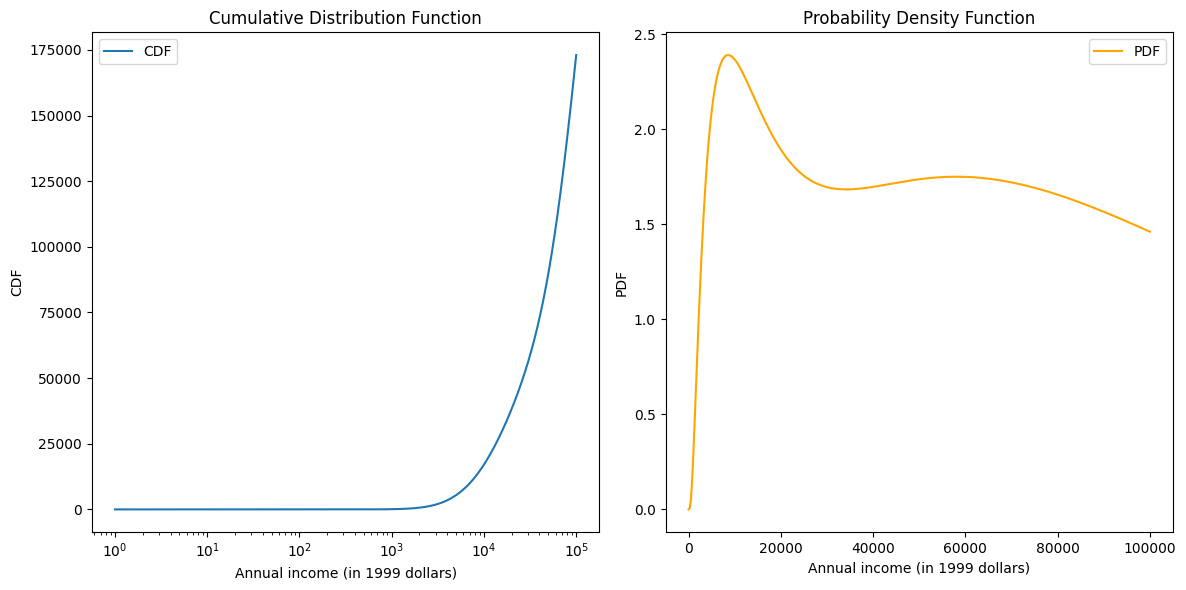

In [42]:
# Define the CDF and PDF functions
def cdf(x, a, u, o, a1, u1, o1):
    return a * (.5 + .5 * erf((np.log(x) - u) / (np.sqrt(2) * o))) + \
           a1 * (.5 + .5 * erf((np.log(x) - u1) / (np.sqrt(2) * o1)))

def pdf(x, a, u, o, a1, u1, o1):
    return a * np.exp(-(np.log(x) - u) ** 2 / (2 * o ** 2)) / (x * o * np.sqrt(2 * np.pi)) + \
           a1 * np.exp(-(np.log(x) - u1) ** 2 / (2 * o1 ** 2)) / (x * o1 * np.sqrt(2 * np.pi))

# Assuming you've defined 'a', 'u', 'o', 'a1', 'u1', 'o1' with your values

# Generating data for plotting
x_values = np.linspace(1, 100000, 400)
cdf_values = cdf(x_values, a, u, o, a1, u1, o1)
pdf_values = pdf(x_values, a, u, o, a1, u1, o1)

# Plotting
plt.figure(figsize=(12, 6))

# CDF plot
plt.subplot(1, 2, 1)
plt.plot(x_values, cdf_values, label='CDF')
plt.xscale('log')
plt.xlabel('Annual income (in 1999 dollars)')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function')
plt.legend()

# PDF plot
plt.subplot(1, 2, 2)
plt.plot(x_values, pdf_values, label='PDF', color='orange')
plt.xlabel('Annual income (in 1999 dollars)')
plt.ylabel('PDF')
plt.title('Probability Density Function')
plt.legend()

plt.tight_layout()
plt.show()